https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346

RNN/LSTM

    Why can’t the traditional neural network model sequential data effectively?
    Since RNN/LSTM/GRU requires a 3-D tensor as input. How to form the training data from the univariate stock price data for RNN/LSTM/GRU?
    How does the RNN work?
    Why LSTM? How does it work?
    Why GRU? How does it work?
    Regularization in RNN/LSTM/GRU? The Dropout technique

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import data
df = pd.read_csv(r'cleaned_data.csv')
df.head()

,Date,TEL_BIO,ADP_SYK,ON_MU,ROST_VFC,CDW_T,PAYX_RTX,APH_STE,NDSN_STE,CAH_NEM,CEG_NEM,DIS_NEM,IT_NEM,NRG_NEM,SCHW_NEM,TT_NEM
0,2022-02-23,0.239509,0.771140,0.663637,1.560298,9.729875,1.237427,0.326856,0.983616,0.781127,0.636250,2.170135,4.069952,0.537846,1.220489,2.195844
1,2022-02-24,0.234301,0.774126,0.689893,1.592246,10.004847,1.227451,0.326426,0.963968,0.784539,0.671616,2.273621,4.282290,0.570192,1.244242,2.280275
2,2022-02-25,0.223696,0.766083,0.707117,1.601182,10.073827,1.208059,0.322575,0.955513,0.796171,0.653839,2.236053,4.284883,0.557495,1.274335,2.292504
3,2022-02-28,0.225564,0.773484,0.706936,1.594907,9.877013,1.158270,0.315486,0.940690,0.813754,0.702244,2.277063,4.301050,0.569553,1.287397,2.339218
4,2022-03-01,0.217456,0.767553,0.693815,1.633461,9.768311,1.143246,0.311195,0.937899,0.763564,0.700168,2.143734,4.038225,0.527591,1.138470,2.216707


In [19]:
df_short=df[["Date", "TEL_BIO"]]
df_short

,Date,TEL_BIO
0,2022-02-23,0.239509
1,2022-02-24,0.234301
2,2022-02-25,0.223696
3,2022-02-28,0.225564
4,2022-03-01,0.217456
...,...,...
121,2022-08-17,0.258362
122,2022-08-18,0.263737
123,2022-08-19,0.264347
124,2022-08-22,0.259488


In [20]:
df_short.shape

(126, 2)

In [21]:
print("There are "+ str(df_short[:100].shape[0]) + " observations in the training data")
print("There are "+ str(df_short[100:].shape[0]) + " observations in the test data")

There are 100 observations in the training data
There are 26 observations in the test data


<AxesSubplot:>

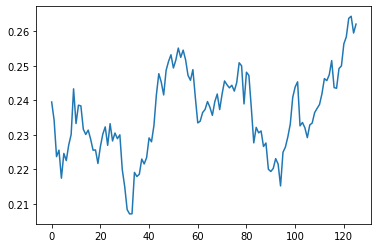

In [23]:
df_short["TEL_BIO"].plot()

In [25]:
def ts_train_test(df,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data till 100
      X_test:  data from 2019 -
    time_steps: # of the input time steps
    for_periods: # of the output time steps
    '''
    # create training and test set
    ts_train = df[:100].iloc[:,0:1].values
    ts_test  = df[100:].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Preparing to create X_test
    inputs = pd.concat((df["TEL_BIO"][:100], df["TEL_BIO"][100:]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

X_train, y_train, X_test = ts_train_test(df,5,2)
X_train.shape[0],X_train.shape[1]

(94, 5)

In [57]:
# Convert the 3-D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

# Convert the 3-D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 94 samples in the training data
There are 24 samples in the test data


In [58]:
#The Code for Input and Output Data
def ts_train_test(df_short,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data till 100
      X_test:  data from 100 -
    time_steps: # of the input time steps
    for_periods: # of the output time steps
    '''
    # create training and test set
    ts_train = df_short[:100].iloc[:,0:1].values
    ts_test  = df_short[100:].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Preparing to create X_test
    inputs = pd.concat((df_short["Adj. Ratio"][:100], df_short["Adj. Ratio"][100:]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

X_train, y_train, X_test = ts_train_test(df_short,5,2)
X_train.shape[0],X_train.shape[1]

KeyError: 'Adj. Ratio'

In [48]:
# Convert the 3-D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

# Convert the 3-D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 94 samples in the training data
There are 24 samples in the test data


In [62]:
#Build a Simple RNN Model
def simple_rnn_model(X_train, y_train, X_test):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)

    return my_rnn_model, rnn_predictions

In [64]:
my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test)
rnn_predictions[1:10]

TypeError: in user code:

    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:830 train_function  *
        return step_function(self, iterator)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:813 run_step  *
        outputs = model.train_step(data)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:770 train_step  *
        y_pred = self(x, training=True)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/engine/base_layer.py:1006 __call__  *
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/engine/sequential.py:389 call  *
        outputs = layer(inputs, **kwargs)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/layers/recurrent.py:660 __call__  *
        return super(RNN, self).__call__(inputs, **kwargs)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/engine/base_layer.py:1006 __call__  *
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/layers/recurrent.py:1577 call  *
        inputs, mask=mask, training=training, initial_state=initial_state)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/layers/recurrent.py:790 step  *
        output, new_states = cell_call_fn(inputs, states, **kwargs)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/backend.py:4126 wrapper  *
        return target(*args, **kwargs)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/backend.py:4342 rnn  *
        output_time_zero, _ = step_function(
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/engine/base_layer.py:1006 __call__  *
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/layers/recurrent.py:1374 call  *
        h = backend.dot(inputs, self.kernel)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/backend.py:4126 wrapper  *
        return target(*args, **kwargs)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/keras/backend.py:1973 dot  *
        out = tf.matmul(x, y)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:3489 matmul
        return gen_math_ops.mat_mul(
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:5716 mat_mul
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:628 _apply_op_helper
        _SatisfiesTypeConstraint(base_type,
    /Users/simoneritter/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:59 _SatisfiesTypeConstraint
        raise TypeError(

    TypeError: Value passed to parameter 'a' has DataType string not in list of allowed values: bfloat16, float16, float32, float64, int32, int64, complex64, complex128


In [63]:
def actual_pred_plot(preds):
    #Plot the actual vs. prediction
    actual_pred = pd.DataFrame(columns = ['Adj. Ratio', 'prediction'])
    actual_pred['Adj. Ratio'] = all_data.loc[100:,'Adj. Ratio'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Ratio']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )
    
actual_pred_plot(rnn_predictions)  

NameError: name 'rnn_predictions' is not defined

In [60]:
def ts_train_test_normalize(df,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = df[:100].iloc[:,0:1].values
    ts_test  = df[100:].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((df["Adj. Ratio"][:100], df["Adj. Ratio"][100:]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    from sklearn.preprocessing import MinMaxScaler
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions


X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_rnn_model, rnn_predictions_2 = simple_rnn_model(X_train, y_train, X_test, sc)
rnn_predictions_2[1:10]
actual_pred_plot(rnn_predictions_2)   

ValueError: could not convert string to float: '2022-02-23'

#LSTM Code

In [ ]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)   

In [ ]:
#LSTM With Regularization

In [ ]:
def LSTM_model_regularization(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
    from keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dropout(0.2))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model_regularization(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)  